## Weather forecast for the next 5 days 

In [ ]:
#Import libraries
import os
import copy
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the datasets
met_stations = pd.read_csv('/content/drive/MyDrive/FYP/met-stations.tsv',sep='\t',index_col=0)
met_forecast = pd.read_csv('/content/drive/MyDrive/FYP/met-forecast.tsv',sep='\t',index_col=0) 
rl_sites = pd.read_csv('/content/drive/MyDrive/FYP/rl-sites.tsv',sep='\t',index_col=0)
rl_kpis = pd.read_csv('/content/drive/MyDrive/FYP/rl-kpis.tsv',sep='\t',index_col=0)
distances = pd.read_csv('/content/drive/MyDrive/FYP/distances.tsv',sep='\t', index_col=0)
met_real = pd.read_csv('/content/drive/MyDrive/FYP/met-real.tsv', sep='\t',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
met_forecast.head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
2,WS_17062,2018-01-02,evening,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
3,WS_17062,2018-01-02,morning,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
4,WS_17063,2018-01-02,evening,heavy rain,13,9,95.0,78.0,87.0,10.0,rain,13,7,95.0,75.0,27.0,14.0,overcast clouds,11,7,92.0,77.0,14.0,14.0,few clouds,14,6,86.0,57.0,134.0,11.0,few clouds,17,10,78.0,63.0,131.0,14.0


In [ ]:
#Converting to date time format
met_forecast['datetime'] = [datetime.datetime.strptime(x.replace('-','/'),'%Y/%m/%d') for x in met_forecast['datetime']]
met_forecast

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
2,WS_17062,2018-01-02,evening,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
3,WS_17062,2018-01-02,morning,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
4,WS_17063,2018-01-02,evening,heavy rain,13,9,95.0,78.0,87.0,10.0,rain,13,7,95.0,75.0,27.0,14.0,overcast clouds,11,7,92.0,77.0,14.0,14.0,few clouds,14,6,86.0,57.0,134.0,11.0,few clouds,17,10,78.0,63.0,131.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20318,WS_18100,2020-12-23,morning,scattered clouds,14,7,81.0,69.0,147.0,11.0,windy,16,9,80.0,62.0,148.0,15.0,windy,17,11,80.0,56.0,150.0,14.0,overcast clouds,15,11,75.0,61.0,155.0,23.0,rain,14,10,92.0,72.0,170.0,14.0
20319,WS_18397,2020-12-23,morning,scattered clouds,13,4,89.0,65.0,225.0,20.0,windy,16,7,87.0,59.0,219.0,28.0,windy,17,11,71.0,58.0,219.0,28.0,overcast clouds,16,12,70.0,54.0,170.0,18.0,rain,13,10,95.0,69.0,208.0,18.0
20320,WS_18403,2020-12-23,morning,scattered clouds,12,6,86.0,69.0,221.0,19.0,windy,15,8,85.0,61.0,220.0,29.0,windy,16,12,72.0,62.0,219.0,27.0,overcast clouds,15,12,75.0,57.0,154.0,20.0,rain,13,10,95.0,75.0,207.0,18.0
20321,WS_18404,2020-12-23,morning,scattered clouds,13,7,86.0,73.0,218.0,20.0,windy,16,10,81.0,62.0,216.0,30.0,windy,17,13,75.0,65.0,217.0,28.0,overcast clouds,16,12,75.0,60.0,204.0,23.0,rain,14,11,94.0,75.0,209.0,19.0


In [ ]:
#Sorting based on Station number and date-time
met_forecast.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
20,WS_17047,2018-01-03,evening,light rain,9,4,96.0,85.0,6.0,19.0,scattered clouds,9,3,92.0,59.0,5.0,19.0,few clouds,10,2,95.0,65.0,194.0,11.0,clear sky,13,5,91.0,67.0,210.0,16.0,clear sky,14,8,94.0,78.0,211.0,16.0
21,WS_17047,2018-01-03,morning,light rain,9,4,96.0,85.0,6.0,19.0,scattered clouds,9,3,92.0,59.0,5.0,19.0,few clouds,10,2,95.0,65.0,194.0,11.0,clear sky,13,5,91.0,67.0,210.0,16.0,clear sky,14,8,94.0,78.0,211.0,16.0
40,WS_17047,2018-01-04,evening,scattered clouds,9,4,91.0,60.0,0.0,16.0,few clouds,10,3,96.0,66.0,190.0,9.0,foggy,12,5,93.0,63.0,207.0,14.0,foggy,13,7,93.0,76.0,216.0,15.0,foggy,12,9,96.0,81.0,213.0,22.0


In [ ]:
#For each sample morning and evening weather condition values were same, hence we drop report_time 
met_forecast_v2=met_forecast
met_forecast_v2.drop('report_time',axis='columns', inplace=True)

In [ ]:
met_forecast_v2.head()

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
2,WS_17062,2018-01-02,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
3,WS_17062,2018-01-02,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
4,WS_17063,2018-01-02,heavy rain,13,9,95.0,78.0,87.0,10.0,rain,13,7,95.0,75.0,27.0,14.0,overcast clouds,11,7,92.0,77.0,14.0,14.0,few clouds,14,6,86.0,57.0,134.0,11.0,few clouds,17,10,78.0,63.0,131.0,14.0


In [ ]:
met_forecast_v2.shape

(20323, 37)

In [ ]:
#Dropping the duplicate values by retaining the first values alone(as the report_time does not matter)
met_forecast_v2=met_forecast_v2.drop_duplicates(keep='first')

In [ ]:
met_forecast_v2.shape

(11649, 37)

In [ ]:
#Sorting based on Station number and date-time
met_forecast_v2.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
20,WS_17047,2018-01-03,light rain,9,4,96.0,85.0,6.0,19.0,scattered clouds,9,3,92.0,59.0,5.0,19.0,few clouds,10,2,95.0,65.0,194.0,11.0,clear sky,13,5,91.0,67.0,210.0,16.0,clear sky,14,8,94.0,78.0,211.0,16.0
40,WS_17047,2018-01-04,scattered clouds,9,4,91.0,60.0,0.0,16.0,few clouds,10,3,96.0,66.0,190.0,9.0,foggy,12,5,93.0,63.0,207.0,14.0,foggy,13,7,93.0,76.0,216.0,15.0,foggy,12,9,96.0,81.0,213.0,22.0
60,WS_17047,2018-01-05,scattered clouds,10,3,96.0,70.0,194.0,9.0,few clouds,12,5,95.0,64.0,210.0,14.0,few clouds,13,7,96.0,74.0,213.0,10.0,scattered clouds,12,9,96.0,80.0,22.0,7.0,few clouds,12,9,96.0,67.0,28.0,9.0
80,WS_17047,2018-01-06,few clouds,11,4,96.0,63.0,209.0,14.0,scattered clouds,13,7,96.0,76.0,246.0,9.0,overcast clouds,12,6,96.0,76.0,49.0,7.0,scattered clouds,11,7,96.0,78.0,31.0,8.0,overcast clouds,10,6,96.0,87.0,34.0,19.0


In [ ]:
#Assigning a number to each weather condition for encoding
n=0
for i in met_forecast_v2["weather_day1"].unique():
  print("'"+i+"'"+':'+str(n)+',')
  n+=1
print(met_forecast_v2["weather_day1"].unique())

'heavy rain':0,
'light rain':1,
'scattered clouds':2,
'overcast clouds':3,
'few clouds':4,
'foggy':5,
'rain':6,
'sleet':7,
'light snow':8,
'misty':9,
'light intensity shower rain':10,
'snow':11,
'thunderstorm with heavy rain':12,
'heavy thunderstorm with rain showers':13,
'light rain showers':14,
'hot day':15,
'heavy rain showers':16,
'windy':17,
'clear sky':18,
['heavy rain' 'light rain' 'scattered clouds' 'overcast clouds'
 'few clouds' 'foggy' 'rain' 'sleet' 'light snow' 'misty'
 'light intensity shower rain' 'snow' 'thunderstorm with heavy rain'
 'heavy thunderstorm with rain showers' 'light rain showers' 'hot day'
 'heavy rain showers' 'windy' 'clear sky']


In [ ]:
#Encoding the weather conditions
cleanup_nums = {"station_no":     {"WS_17047": 0, "WS_17062": 1,"WS_17063": 2,"WS_17064": 3,"WS_17065": 4,'WS_17610': 5, "WS_18100": 6,"WS_18397": 7,"WS_18403": 8,"WS_18404": 9, "WS_19111": 10},
                "weather_day1": {'heavy rain':0,'light rain':1,'scattered clouds':2,'overcast clouds':3,'few clouds':4,'foggy':5,'rain':6,'sleet':7,'light snow':8,'misty':9,'light intensity shower rain':10,'snow':11,'thunderstorm with heavy rain':12,'heavy thunderstorm with rain showers':13,'light rain showers':14,'hot day':15,'heavy rain showers':16,'windy':17,'clear sky':18},
"weather_day2": {'heavy rain':0,'light rain':1,'scattered clouds':2,'overcast clouds':3,'few clouds':4,'foggy':5,'rain':6,'sleet':7,'light snow':8,'misty':9,'light intensity shower rain':10,'snow':11,'thunderstorm with heavy rain':12,'heavy thunderstorm with rain showers':13,'light rain showers':14,'hot day':15,'heavy rain showers':16,'windy':17,'clear sky':18},
"weather_day3": {'heavy rain':0,'light rain':1,'scattered clouds':2,'overcast clouds':3,'few clouds':4,'foggy':5,'rain':6,'sleet':7,'light snow':8,'misty':9,'light intensity shower rain':10,'snow':11,'thunderstorm with heavy rain':12,'heavy thunderstorm with rain showers':13,'light rain showers':14,'hot day':15,'heavy rain showers':16,'windy':17,'clear sky':18},
"weather_day4": {'heavy rain':0,'light rain':1,'scattered clouds':2,'overcast clouds':3,'few clouds':4,'foggy':5,'rain':6,'sleet':7,'light snow':8,'misty':9,'light intensity shower rain':10,'snow':11,'thunderstorm with heavy rain':12,'heavy thunderstorm with rain showers':13,'light rain showers':14,'hot day':15,'heavy rain showers':16,'windy':17,'clear sky':18},
"weather_day5": {'heavy rain':0,'light rain':1,'scattered clouds':2,'overcast clouds':3,'few clouds':4,'foggy':5,'rain':6,'sleet':7,'light snow':8,'misty':9,'light intensity shower rain':10,'snow':11,'thunderstorm with heavy rain':12,'heavy thunderstorm with rain showers':13,'light rain showers':14,'hot day':15,'heavy rain showers':16,'windy':17,'clear sky':18}

                }
met_forecast_v2 = met_forecast_v2.replace(cleanup_nums)
met_forecast_v2.head()

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0,2018-01-02,0,10,6,96.0,82.0,6.0,19.0,6,9,5,96.0,78.0,5.0,18.0,3,10,2,93.0,69.0,213.0,14.0,4,12,4,92.0,57.0,185.0,12.0,4.0,14,8,90.0,70.0,210.0,16.0
2,1,2018-01-02,0,12,9,96.0,80.0,84.0,10.0,6,12,8,96.0,80.0,24.0,14.0,3,12,6,89.0,75.0,228.0,16.0,4,14,7,86.0,57.0,114.0,10.0,4.0,17,10,78.0,67.0,107.0,14.0
4,2,2018-01-02,0,13,9,95.0,78.0,87.0,10.0,6,13,7,95.0,75.0,27.0,14.0,3,11,7,92.0,77.0,14.0,14.0,4,14,6,86.0,57.0,134.0,11.0,4.0,17,10,78.0,63.0,131.0,14.0
6,3,2018-01-02,0,11,8,96.0,78.0,92.0,10.0,6,11,7,95.0,79.0,26.0,15.0,3,10,7,90.0,76.0,13.0,15.0,4,14,5,86.0,60.0,111.0,11.0,4.0,16,9,77.0,67.0,107.0,14.0
8,4,2018-01-02,0,11,7,96.0,77.0,54.0,8.0,6,11,6,96.0,87.0,27.0,10.0,3,10,4,94.0,71.0,227.0,14.0,4,13,5,86.0,49.0,151.0,10.0,4.0,15,8,75.0,59.0,148.0,13.0


In [ ]:
#Sorting based on Station number and date-time
met_forecast_v2.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0,2018-01-02,0,10,6,96.0,82.0,6.0,19.0,6,9,5,96.0,78.0,5.0,18.0,3,10,2,93.0,69.0,213.0,14.0,4,12,4,92.0,57.0,185.0,12.0,4.0,14,8,90.0,70.0,210.0,16.0
20,0,2018-01-03,1,9,4,96.0,85.0,6.0,19.0,2,9,3,92.0,59.0,5.0,19.0,4,10,2,95.0,65.0,194.0,11.0,18,13,5,91.0,67.0,210.0,16.0,18.0,14,8,94.0,78.0,211.0,16.0
40,0,2018-01-04,2,9,4,91.0,60.0,0.0,16.0,4,10,3,96.0,66.0,190.0,9.0,5,12,5,93.0,63.0,207.0,14.0,5,13,7,93.0,76.0,216.0,15.0,5.0,12,9,96.0,81.0,213.0,22.0
60,0,2018-01-05,2,10,3,96.0,70.0,194.0,9.0,4,12,5,95.0,64.0,210.0,14.0,4,13,7,96.0,74.0,213.0,10.0,2,12,9,96.0,80.0,22.0,7.0,4.0,12,9,96.0,67.0,28.0,9.0
80,0,2018-01-06,4,11,4,96.0,63.0,209.0,14.0,2,13,7,96.0,76.0,246.0,9.0,3,12,6,96.0,76.0,49.0,7.0,2,11,7,96.0,78.0,31.0,8.0,3.0,10,6,96.0,87.0,34.0,19.0


In [ ]:
met_forecast_v2

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0,2018-01-02,0,10,6,96.0,82.0,6.0,19.0,6,9,5,96.0,78.0,5.0,18.0,3,10,2,93.0,69.0,213.0,14.0,4,12,4,92.0,57.0,185.0,12.0,4.0,14,8,90.0,70.0,210.0,16.0
2,1,2018-01-02,0,12,9,96.0,80.0,84.0,10.0,6,12,8,96.0,80.0,24.0,14.0,3,12,6,89.0,75.0,228.0,16.0,4,14,7,86.0,57.0,114.0,10.0,4.0,17,10,78.0,67.0,107.0,14.0
4,2,2018-01-02,0,13,9,95.0,78.0,87.0,10.0,6,13,7,95.0,75.0,27.0,14.0,3,11,7,92.0,77.0,14.0,14.0,4,14,6,86.0,57.0,134.0,11.0,4.0,17,10,78.0,63.0,131.0,14.0
6,3,2018-01-02,0,11,8,96.0,78.0,92.0,10.0,6,11,7,95.0,79.0,26.0,15.0,3,10,7,90.0,76.0,13.0,15.0,4,14,5,86.0,60.0,111.0,11.0,4.0,16,9,77.0,67.0,107.0,14.0
8,4,2018-01-02,0,11,7,96.0,77.0,54.0,8.0,6,11,6,96.0,87.0,27.0,10.0,3,10,4,94.0,71.0,227.0,14.0,4,13,5,86.0,49.0,151.0,10.0,4.0,15,8,75.0,59.0,148.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20318,6,2020-12-23,2,14,7,81.0,69.0,147.0,11.0,17,16,9,80.0,62.0,148.0,15.0,17,17,11,80.0,56.0,150.0,14.0,3,15,11,75.0,61.0,155.0,23.0,6.0,14,10,92.0,72.0,170.0,14.0
20319,7,2020-12-23,2,13,4,89.0,65.0,225.0,20.0,17,16,7,87.0,59.0,219.0,28.0,17,17,11,71.0,58.0,219.0,28.0,3,16,12,70.0,54.0,170.0,18.0,6.0,13,10,95.0,69.0,208.0,18.0
20320,8,2020-12-23,2,12,6,86.0,69.0,221.0,19.0,17,15,8,85.0,61.0,220.0,29.0,17,16,12,72.0,62.0,219.0,27.0,3,15,12,75.0,57.0,154.0,20.0,6.0,13,10,95.0,75.0,207.0,18.0
20321,9,2020-12-23,2,13,7,86.0,73.0,218.0,20.0,17,16,10,81.0,62.0,216.0,30.0,17,17,13,75.0,65.0,217.0,28.0,3,16,12,75.0,60.0,204.0,23.0,6.0,14,11,94.0,75.0,209.0,19.0


In [ ]:
met_forecast_v2.reset_index(inplace=True)

In [ ]:
met_forecast_v2

,index,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0,0,2018-01-02,0,10,6,96.0,82.0,6.0,19.0,6,9,5,96.0,78.0,5.0,18.0,3,10,2,93.0,69.0,213.0,14.0,4,12,4,92.0,57.0,185.0,12.0,4.0,14,8,90.0,70.0,210.0,16.0
1,2,1,2018-01-02,0,12,9,96.0,80.0,84.0,10.0,6,12,8,96.0,80.0,24.0,14.0,3,12,6,89.0,75.0,228.0,16.0,4,14,7,86.0,57.0,114.0,10.0,4.0,17,10,78.0,67.0,107.0,14.0
2,4,2,2018-01-02,0,13,9,95.0,78.0,87.0,10.0,6,13,7,95.0,75.0,27.0,14.0,3,11,7,92.0,77.0,14.0,14.0,4,14,6,86.0,57.0,134.0,11.0,4.0,17,10,78.0,63.0,131.0,14.0
3,6,3,2018-01-02,0,11,8,96.0,78.0,92.0,10.0,6,11,7,95.0,79.0,26.0,15.0,3,10,7,90.0,76.0,13.0,15.0,4,14,5,86.0,60.0,111.0,11.0,4.0,16,9,77.0,67.0,107.0,14.0
4,8,4,2018-01-02,0,11,7,96.0,77.0,54.0,8.0,6,11,6,96.0,87.0,27.0,10.0,3,10,4,94.0,71.0,227.0,14.0,4,13,5,86.0,49.0,151.0,10.0,4.0,15,8,75.0,59.0,148.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11644,20318,6,2020-12-23,2,14,7,81.0,69.0,147.0,11.0,17,16,9,80.0,62.0,148.0,15.0,17,17,11,80.0,56.0,150.0,14.0,3,15,11,75.0,61.0,155.0,23.0,6.0,14,10,92.0,72.0,170.0,14.0
11645,20319,7,2020-12-23,2,13,4,89.0,65.0,225.0,20.0,17,16,7,87.0,59.0,219.0,28.0,17,17,11,71.0,58.0,219.0,28.0,3,16,12,70.0,54.0,170.0,18.0,6.0,13,10,95.0,69.0,208.0,18.0
11646,20320,8,2020-12-23,2,12,6,86.0,69.0,221.0,19.0,17,15,8,85.0,61.0,220.0,29.0,17,16,12,72.0,62.0,219.0,27.0,3,15,12,75.0,57.0,154.0,20.0,6.0,13,10,95.0,75.0,207.0,18.0
11647,20321,9,2020-12-23,2,13,7,86.0,73.0,218.0,20.0,17,16,10,81.0,62.0,216.0,30.0,17,17,13,75.0,65.0,217.0,28.0,3,16,12,75.0,60.0,204.0,23.0,6.0,14,11,94.0,75.0,209.0,19.0


In [ ]:
met_forecast_v2.columns

Index(['index', 'station_no', 'datetime', 'weather_day1', 'temp_max_day1',
       'temp_min_day1', 'humidity_max_day1', 'humidity_min_day1',
       'wind_dir_day1', 'wind_speed_day1', 'weather_day2', 'temp_max_day2',
       'temp_min_day2', 'humidity_max_day2', 'humidity_min_day2',
       'wind_dir_day2', 'wind_speed_day2', 'weather_day3', 'temp_max_day3',
       'temp_min_day3', 'humidity_max_day3', 'humidity_min_day3',
       'wind_dir_day3', 'wind_speed_day3', 'weather_day4', 'temp_max_day4',
       'temp_min_day4', 'humidity_max_day4', 'humidity_min_day4',
       'wind_dir_day4', 'wind_speed_day4', 'weather_day5', 'temp_max_day5',
       'temp_min_day5', 'humidity_max_day5', 'humidity_min_day5',
       'wind_dir_day5', 'wind_speed_day5'],
      dtype='object')

In [ ]:
#Dropping an additional index column
met_forecast_v2.drop('index',axis='columns', inplace=True)
met_forecast_v2 

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0,2018-01-02,0,10,6,96.0,82.0,6.0,19.0,6,9,5,96.0,78.0,5.0,18.0,3,10,2,93.0,69.0,213.0,14.0,4,12,4,92.0,57.0,185.0,12.0,4.0,14,8,90.0,70.0,210.0,16.0
1,1,2018-01-02,0,12,9,96.0,80.0,84.0,10.0,6,12,8,96.0,80.0,24.0,14.0,3,12,6,89.0,75.0,228.0,16.0,4,14,7,86.0,57.0,114.0,10.0,4.0,17,10,78.0,67.0,107.0,14.0
2,2,2018-01-02,0,13,9,95.0,78.0,87.0,10.0,6,13,7,95.0,75.0,27.0,14.0,3,11,7,92.0,77.0,14.0,14.0,4,14,6,86.0,57.0,134.0,11.0,4.0,17,10,78.0,63.0,131.0,14.0
3,3,2018-01-02,0,11,8,96.0,78.0,92.0,10.0,6,11,7,95.0,79.0,26.0,15.0,3,10,7,90.0,76.0,13.0,15.0,4,14,5,86.0,60.0,111.0,11.0,4.0,16,9,77.0,67.0,107.0,14.0
4,4,2018-01-02,0,11,7,96.0,77.0,54.0,8.0,6,11,6,96.0,87.0,27.0,10.0,3,10,4,94.0,71.0,227.0,14.0,4,13,5,86.0,49.0,151.0,10.0,4.0,15,8,75.0,59.0,148.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11644,6,2020-12-23,2,14,7,81.0,69.0,147.0,11.0,17,16,9,80.0,62.0,148.0,15.0,17,17,11,80.0,56.0,150.0,14.0,3,15,11,75.0,61.0,155.0,23.0,6.0,14,10,92.0,72.0,170.0,14.0
11645,7,2020-12-23,2,13,4,89.0,65.0,225.0,20.0,17,16,7,87.0,59.0,219.0,28.0,17,17,11,71.0,58.0,219.0,28.0,3,16,12,70.0,54.0,170.0,18.0,6.0,13,10,95.0,69.0,208.0,18.0
11646,8,2020-12-23,2,12,6,86.0,69.0,221.0,19.0,17,15,8,85.0,61.0,220.0,29.0,17,16,12,72.0,62.0,219.0,27.0,3,15,12,75.0,57.0,154.0,20.0,6.0,13,10,95.0,75.0,207.0,18.0
11647,9,2020-12-23,2,13,7,86.0,73.0,218.0,20.0,17,16,10,81.0,62.0,216.0,30.0,17,17,13,75.0,65.0,217.0,28.0,3,16,12,75.0,60.0,204.0,23.0,6.0,14,11,94.0,75.0,209.0,19.0


In [ ]:
#Checking if all data types are integer or float, which is necessary for LSTM
met_forecast_v2.dtypes

station_no                    int64
datetime             datetime64[ns]
weather_day1                  int64
temp_max_day1                 int64
temp_min_day1                 int64
humidity_max_day1           float64
humidity_min_day1           float64
wind_dir_day1               float64
wind_speed_day1             float64
weather_day2                  int64
temp_max_day2                 int64
temp_min_day2                 int64
humidity_max_day2           float64
humidity_min_day2           float64
wind_dir_day2               float64
wind_speed_day2             float64
weather_day3                  int64
temp_max_day3                 int64
temp_min_day3                 int64
humidity_max_day3           float64
humidity_min_day3           float64
wind_dir_day3               float64
wind_speed_day3             float64
weather_day4                  int64
temp_max_day4                 int64
temp_min_day4                 int64
humidity_max_day4           float64
humidity_min_day4           

In [ ]:
#Checking null values
met_forecast_v2.isnull().sum()

station_no              0
datetime                0
weather_day1            0
temp_max_day1           0
temp_min_day1           0
humidity_max_day1    1218
humidity_min_day1    1218
wind_dir_day1        1218
wind_speed_day1      1218
weather_day2            0
temp_max_day2           0
temp_min_day2           0
humidity_max_day2    1218
humidity_min_day2    1218
wind_dir_day2        1218
wind_speed_day2      1218
weather_day3            0
temp_max_day3           0
temp_min_day3           0
humidity_max_day3    1218
humidity_min_day3    1218
wind_dir_day3        1218
wind_speed_day3      1218
weather_day4            0
temp_max_day4           0
temp_min_day4           0
humidity_max_day4    1218
humidity_min_day4    1218
wind_dir_day4        1218
wind_speed_day4      1218
weather_day5          294
temp_max_day5           0
temp_min_day5           0
humidity_max_day5    1218
humidity_min_day5    1218
wind_dir_day5        1218
wind_speed_day5      1413
dtype: int64

In [ ]:
#Total number of null values in the entire dataset
met_forecast_v2.isnull().values.ravel().sum()

24849

In [ ]:
#Checking for nan values
nan_forecast=met_forecast_v2[met_forecast_v2.isna().any(axis=1)]
nan_forecast

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
301,0,2018-01-28,5,9,1,95.0,69.0,248.0,12.0,5,10,3,96.0,64.0,222.0,17.0,2,8,2,88.0,50.0,5.0,10.0,2,10,3,93.0,55.0,218.0,17.0,NaN,12,7,82.0,70.0,209.0,34.0
303,1,2018-01-28,5,11,4,91.0,80.0,236.0,16.0,5,13,6,89.0,70.0,233.0,17.0,2,12,6,90.0,55.0,320.0,9.0,2,14,6,83.0,63.0,231.0,19.0,NaN,16,11,78.0,66.0,226.0,38.0
305,2,2018-01-28,5,11,3,91.0,77.0,251.0,12.0,5,13,6,90.0,64.0,129.0,8.0,2,11,5,93.0,72.0,276.0,10.0,2,13,5,81.0,50.0,210.0,12.0,NaN,15,10,85.0,63.0,245.0,28.0
307,3,2018-01-28,5,11,3,89.0,79.0,244.0,14.0,5,13,6,90.0,69.0,242.0,13.0,2,11,5,91.0,68.0,285.0,9.0,2,13,5,82.0,53.0,227.0,18.0,NaN,15,10,78.0,66.0,236.0,33.0
309,4,2018-01-28,5,10,2,96.0,78.0,241.0,14.0,5,12,4,92.0,61.0,230.0,17.0,2,10,4,95.0,53.0,340.0,13.0,2,13,5,82.0,51.0,216.0,15.0,NaN,14,9,78.0,63.0,227.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607,10,2020-12-19,1,10,5,NaN,NaN,NaN,NaN,1,9,7,NaN,NaN,NaN,NaN,3,8,3,NaN,NaN,NaN,NaN,3,8,2,NaN,NaN,NaN,NaN,2.0,12,6,NaN,NaN,NaN,NaN
11617,10,2020-12-20,6,9,6,NaN,NaN,NaN,NaN,6,8,4,NaN,NaN,NaN,NaN,3,8,1,NaN,NaN,NaN,NaN,2,11,5,NaN,NaN,NaN,NaN,4.0,14,8,NaN,NaN,NaN,NaN
11627,10,2020-12-21,3,8,5,NaN,NaN,NaN,NaN,2,7,1,NaN,NaN,NaN,NaN,2,12,4,NaN,NaN,NaN,NaN,3,14,8,NaN,NaN,NaN,NaN,3.0,16,12,NaN,NaN,NaN,NaN
11638,10,2020-12-22,1,8,2,NaN,NaN,NaN,NaN,4,12,6,NaN,NaN,NaN,NaN,3,15,9,NaN,NaN,NaN,NaN,6,16,12,NaN,NaN,NaN,NaN,6.0,16,10,NaN,NaN,NaN,NaN


In [ ]:
#Total nan values in the entire dataset
nan_forecast.isnull().values.ravel().sum()

24849

In [ ]:
met_forecast_v2.dropna(inplace=True)
met_forecast_v2.shape

(9989, 37)

In [ ]:
column_list=list(met_forecast_v2.columns)
column_list

['station_no',
 'datetime',
 'weather_day1',
 'temp_max_day1',
 'temp_min_day1',
 'humidity_max_day1',
 'humidity_min_day1',
 'wind_dir_day1',
 'wind_speed_day1',
 'weather_day2',
 'temp_max_day2',
 'temp_min_day2',
 'humidity_max_day2',
 'humidity_min_day2',
 'wind_dir_day2',
 'wind_speed_day2',
 'weather_day3',
 'temp_max_day3',
 'temp_min_day3',
 'humidity_max_day3',
 'humidity_min_day3',
 'wind_dir_day3',
 'wind_speed_day3',
 'weather_day4',
 'temp_max_day4',
 'temp_min_day4',
 'humidity_max_day4',
 'humidity_min_day4',
 'wind_dir_day4',
 'wind_speed_day4',
 'weather_day5',
 'temp_max_day5',
 'temp_min_day5',
 'humidity_max_day5',
 'humidity_min_day5',
 'wind_dir_day5',
 'wind_speed_day5']

In [ ]:
column_list.remove('datetime')

In [ ]:
# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
met_forecast_v2[column_list] = scaler.fit_transform(met_forecast_v2[column_list])

In [ ]:
met_forecast_v2

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0.000000,2018-01-02,0.000000,0.250000,0.333333,1.000000,0.833333,0.016667,0.304348,0.333333,0.250000,0.264706,1.000000,0.757143,0.013889,0.255319,0.166667,0.250000,0.18750,0.930233,0.619718,0.591667,0.187500,0.222222,0.305556,0.225,0.902439,0.525641,0.513889,0.145833,0.222222,0.388889,0.413793,0.846154,0.671233,0.583333,0.234043
1,0.111111,2018-01-02,0.000000,0.305556,0.424242,1.000000,0.805556,0.233333,0.108696,0.333333,0.333333,0.352941,1.000000,0.785714,0.066667,0.170213,0.166667,0.305556,0.31250,0.837209,0.704225,0.633333,0.229167,0.222222,0.361111,0.300,0.756098,0.525641,0.316667,0.104167,0.222222,0.472222,0.482759,0.538462,0.630137,0.297222,0.191489
2,0.222222,2018-01-02,0.000000,0.333333,0.424242,0.974359,0.777778,0.241667,0.108696,0.333333,0.361111,0.323529,0.976190,0.714286,0.075000,0.170213,0.166667,0.277778,0.34375,0.906977,0.732394,0.038889,0.187500,0.222222,0.361111,0.275,0.756098,0.525641,0.372222,0.125000,0.222222,0.472222,0.482759,0.538462,0.575342,0.363889,0.191489
3,0.333333,2018-01-02,0.000000,0.277778,0.393939,1.000000,0.777778,0.255556,0.108696,0.333333,0.305556,0.323529,0.976190,0.771429,0.072222,0.191489,0.166667,0.250000,0.34375,0.860465,0.718310,0.036111,0.208333,0.222222,0.361111,0.250,0.756098,0.564103,0.308333,0.125000,0.222222,0.444444,0.448276,0.512821,0.630137,0.297222,0.191489
4,0.444444,2018-01-02,0.000000,0.277778,0.363636,1.000000,0.763889,0.150000,0.065217,0.333333,0.305556,0.294118,1.000000,0.885714,0.075000,0.085106,0.166667,0.250000,0.25000,0.953488,0.647887,0.630556,0.187500,0.222222,0.333333,0.250,0.756098,0.423077,0.419444,0.104167,0.222222,0.416667,0.413793,0.461538,0.520548,0.411111,0.170213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11643,0.555556,2020-12-23,0.111111,0.333333,0.333333,0.589744,0.652778,0.638889,0.369565,0.944444,0.444444,0.352941,0.523810,0.485714,0.605556,0.361702,0.944444,0.444444,0.46875,0.465116,0.535211,0.600000,0.416667,0.166667,0.416667,0.425,0.317073,0.551282,0.500000,0.354167,0.333333,0.388889,0.482759,0.871795,0.616438,0.641667,0.319149
11644,0.666667,2020-12-23,0.111111,0.361111,0.363636,0.615385,0.652778,0.408333,0.130435,0.944444,0.444444,0.382353,0.619048,0.528571,0.411111,0.191489,0.944444,0.444444,0.46875,0.627907,0.436620,0.416667,0.187500,0.166667,0.388889,0.400,0.487805,0.576923,0.430556,0.375000,0.333333,0.388889,0.482759,0.897436,0.698630,0.472222,0.191489
11645,0.777778,2020-12-23,0.111111,0.333333,0.272727,0.820513,0.597222,0.625000,0.326087,0.944444,0.444444,0.323529,0.785714,0.485714,0.608333,0.468085,0.944444,0.444444,0.46875,0.418605,0.464789,0.608333,0.479167,0.166667,0.416667,0.425,0.365854,0.487179,0.472222,0.270833,0.333333,0.361111,0.482759,0.974359,0.657534,0.577778,0.276596
11646,0.888889,2020-12-23,0.111111,0.305556,0.333333,0.743590,0.652778,0.613889,0.304348,0.944444,0.416667,0.352941,0.738095,0.514286,0.611111,0.489362,0.944444,0.416667,0.50000,0.441860,0.521127,0.608333,0.458333,0.166667,0.388889,0.425,0.487805,0.525641,0.427778,0.312500,0.333333,0.361111,0.482759,0.974359,0.739726,0.575000,0.276596


In [ ]:
met_forecast_v2=met_forecast_v2.reset_index()

In [ ]:
met_forecast_v2.drop('index',axis='columns', inplace=True)
met_forecast_v2

,station_no,datetime,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0.000000,2018-01-02,0.000000,0.250000,0.333333,1.000000,0.833333,0.016667,0.304348,0.333333,0.250000,0.264706,1.000000,0.757143,0.013889,0.255319,0.166667,0.250000,0.18750,0.930233,0.619718,0.591667,0.187500,0.222222,0.305556,0.225,0.902439,0.525641,0.513889,0.145833,0.222222,0.388889,0.413793,0.846154,0.671233,0.583333,0.234043
1,0.111111,2018-01-02,0.000000,0.305556,0.424242,1.000000,0.805556,0.233333,0.108696,0.333333,0.333333,0.352941,1.000000,0.785714,0.066667,0.170213,0.166667,0.305556,0.31250,0.837209,0.704225,0.633333,0.229167,0.222222,0.361111,0.300,0.756098,0.525641,0.316667,0.104167,0.222222,0.472222,0.482759,0.538462,0.630137,0.297222,0.191489
2,0.222222,2018-01-02,0.000000,0.333333,0.424242,0.974359,0.777778,0.241667,0.108696,0.333333,0.361111,0.323529,0.976190,0.714286,0.075000,0.170213,0.166667,0.277778,0.34375,0.906977,0.732394,0.038889,0.187500,0.222222,0.361111,0.275,0.756098,0.525641,0.372222,0.125000,0.222222,0.472222,0.482759,0.538462,0.575342,0.363889,0.191489
3,0.333333,2018-01-02,0.000000,0.277778,0.393939,1.000000,0.777778,0.255556,0.108696,0.333333,0.305556,0.323529,0.976190,0.771429,0.072222,0.191489,0.166667,0.250000,0.34375,0.860465,0.718310,0.036111,0.208333,0.222222,0.361111,0.250,0.756098,0.564103,0.308333,0.125000,0.222222,0.444444,0.448276,0.512821,0.630137,0.297222,0.191489
4,0.444444,2018-01-02,0.000000,0.277778,0.363636,1.000000,0.763889,0.150000,0.065217,0.333333,0.305556,0.294118,1.000000,0.885714,0.075000,0.085106,0.166667,0.250000,0.25000,0.953488,0.647887,0.630556,0.187500,0.222222,0.333333,0.250,0.756098,0.423077,0.419444,0.104167,0.222222,0.416667,0.413793,0.461538,0.520548,0.411111,0.170213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0.555556,2020-12-23,0.111111,0.333333,0.333333,0.589744,0.652778,0.638889,0.369565,0.944444,0.444444,0.352941,0.523810,0.485714,0.605556,0.361702,0.944444,0.444444,0.46875,0.465116,0.535211,0.600000,0.416667,0.166667,0.416667,0.425,0.317073,0.551282,0.500000,0.354167,0.333333,0.388889,0.482759,0.871795,0.616438,0.641667,0.319149
9985,0.666667,2020-12-23,0.111111,0.361111,0.363636,0.615385,0.652778,0.408333,0.130435,0.944444,0.444444,0.382353,0.619048,0.528571,0.411111,0.191489,0.944444,0.444444,0.46875,0.627907,0.436620,0.416667,0.187500,0.166667,0.388889,0.400,0.487805,0.576923,0.430556,0.375000,0.333333,0.388889,0.482759,0.897436,0.698630,0.472222,0.191489
9986,0.777778,2020-12-23,0.111111,0.333333,0.272727,0.820513,0.597222,0.625000,0.326087,0.944444,0.444444,0.323529,0.785714,0.485714,0.608333,0.468085,0.944444,0.444444,0.46875,0.418605,0.464789,0.608333,0.479167,0.166667,0.416667,0.425,0.365854,0.487179,0.472222,0.270833,0.333333,0.361111,0.482759,0.974359,0.657534,0.577778,0.276596
9987,0.888889,2020-12-23,0.111111,0.305556,0.333333,0.743590,0.652778,0.613889,0.304348,0.944444,0.416667,0.352941,0.738095,0.514286,0.611111,0.489362,0.944444,0.416667,0.50000,0.441860,0.521127,0.608333,0.458333,0.166667,0.388889,0.425,0.487805,0.525641,0.427778,0.312500,0.333333,0.361111,0.482759,0.974359,0.739726,0.575000,0.276596


In [ ]:
met_forecast_v2.drop('datetime',axis='columns', inplace=True)
met_forecast_v2

,station_no,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0.000000,0.000000,0.250000,0.333333,1.000000,0.833333,0.016667,0.304348,0.333333,0.250000,0.264706,1.000000,0.757143,0.013889,0.255319,0.166667,0.250000,0.18750,0.930233,0.619718,0.591667,0.187500,0.222222,0.305556,0.225,0.902439,0.525641,0.513889,0.145833,0.222222,0.388889,0.413793,0.846154,0.671233,0.583333,0.234043
1,0.111111,0.000000,0.305556,0.424242,1.000000,0.805556,0.233333,0.108696,0.333333,0.333333,0.352941,1.000000,0.785714,0.066667,0.170213,0.166667,0.305556,0.31250,0.837209,0.704225,0.633333,0.229167,0.222222,0.361111,0.300,0.756098,0.525641,0.316667,0.104167,0.222222,0.472222,0.482759,0.538462,0.630137,0.297222,0.191489
2,0.222222,0.000000,0.333333,0.424242,0.974359,0.777778,0.241667,0.108696,0.333333,0.361111,0.323529,0.976190,0.714286,0.075000,0.170213,0.166667,0.277778,0.34375,0.906977,0.732394,0.038889,0.187500,0.222222,0.361111,0.275,0.756098,0.525641,0.372222,0.125000,0.222222,0.472222,0.482759,0.538462,0.575342,0.363889,0.191489
3,0.333333,0.000000,0.277778,0.393939,1.000000,0.777778,0.255556,0.108696,0.333333,0.305556,0.323529,0.976190,0.771429,0.072222,0.191489,0.166667,0.250000,0.34375,0.860465,0.718310,0.036111,0.208333,0.222222,0.361111,0.250,0.756098,0.564103,0.308333,0.125000,0.222222,0.444444,0.448276,0.512821,0.630137,0.297222,0.191489
4,0.444444,0.000000,0.277778,0.363636,1.000000,0.763889,0.150000,0.065217,0.333333,0.305556,0.294118,1.000000,0.885714,0.075000,0.085106,0.166667,0.250000,0.25000,0.953488,0.647887,0.630556,0.187500,0.222222,0.333333,0.250,0.756098,0.423077,0.419444,0.104167,0.222222,0.416667,0.413793,0.461538,0.520548,0.411111,0.170213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0.555556,0.111111,0.333333,0.333333,0.589744,0.652778,0.638889,0.369565,0.944444,0.444444,0.352941,0.523810,0.485714,0.605556,0.361702,0.944444,0.444444,0.46875,0.465116,0.535211,0.600000,0.416667,0.166667,0.416667,0.425,0.317073,0.551282,0.500000,0.354167,0.333333,0.388889,0.482759,0.871795,0.616438,0.641667,0.319149
9985,0.666667,0.111111,0.361111,0.363636,0.615385,0.652778,0.408333,0.130435,0.944444,0.444444,0.382353,0.619048,0.528571,0.411111,0.191489,0.944444,0.444444,0.46875,0.627907,0.436620,0.416667,0.187500,0.166667,0.388889,0.400,0.487805,0.576923,0.430556,0.375000,0.333333,0.388889,0.482759,0.897436,0.698630,0.472222,0.191489
9986,0.777778,0.111111,0.333333,0.272727,0.820513,0.597222,0.625000,0.326087,0.944444,0.444444,0.323529,0.785714,0.485714,0.608333,0.468085,0.944444,0.444444,0.46875,0.418605,0.464789,0.608333,0.479167,0.166667,0.416667,0.425,0.365854,0.487179,0.472222,0.270833,0.333333,0.361111,0.482759,0.974359,0.657534,0.577778,0.276596
9987,0.888889,0.111111,0.305556,0.333333,0.743590,0.652778,0.613889,0.304348,0.944444,0.416667,0.352941,0.738095,0.514286,0.611111,0.489362,0.944444,0.416667,0.50000,0.441860,0.521127,0.608333,0.458333,0.166667,0.388889,0.425,0.487805,0.525641,0.427778,0.312500,0.333333,0.361111,0.482759,0.974359,0.739726,0.575000,0.276596


In [ ]:
# List of columns are obtained for input and output of LSTM
# Input includes the station number and weather for current day and output includes the weather for the next 5 days

# X=met_forecast_v2[:][['station_no','weather_day1']]
# X
column_list=list(met_forecast_v2.columns)
x_list=column_list[0:8]
y_list=column_list[8:]
X=met_forecast_v2[:][x_list]
y=met_forecast_v2[:][y_list]

In [ ]:
y

,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,0.333333,0.250000,0.264706,1.000000,0.757143,0.013889,0.255319,0.166667,0.250000,0.18750,0.930233,0.619718,0.591667,0.187500,0.222222,0.305556,0.225,0.902439,0.525641,0.513889,0.145833,0.222222,0.388889,0.413793,0.846154,0.671233,0.583333,0.234043
1,0.333333,0.333333,0.352941,1.000000,0.785714,0.066667,0.170213,0.166667,0.305556,0.31250,0.837209,0.704225,0.633333,0.229167,0.222222,0.361111,0.300,0.756098,0.525641,0.316667,0.104167,0.222222,0.472222,0.482759,0.538462,0.630137,0.297222,0.191489
2,0.333333,0.361111,0.323529,0.976190,0.714286,0.075000,0.170213,0.166667,0.277778,0.34375,0.906977,0.732394,0.038889,0.187500,0.222222,0.361111,0.275,0.756098,0.525641,0.372222,0.125000,0.222222,0.472222,0.482759,0.538462,0.575342,0.363889,0.191489
3,0.333333,0.305556,0.323529,0.976190,0.771429,0.072222,0.191489,0.166667,0.250000,0.34375,0.860465,0.718310,0.036111,0.208333,0.222222,0.361111,0.250,0.756098,0.564103,0.308333,0.125000,0.222222,0.444444,0.448276,0.512821,0.630137,0.297222,0.191489
4,0.333333,0.305556,0.294118,1.000000,0.885714,0.075000,0.085106,0.166667,0.250000,0.25000,0.953488,0.647887,0.630556,0.187500,0.222222,0.333333,0.250,0.756098,0.423077,0.419444,0.104167,0.222222,0.416667,0.413793,0.461538,0.520548,0.411111,0.170213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0.944444,0.444444,0.352941,0.523810,0.485714,0.605556,0.361702,0.944444,0.444444,0.46875,0.465116,0.535211,0.600000,0.416667,0.166667,0.416667,0.425,0.317073,0.551282,0.500000,0.354167,0.333333,0.388889,0.482759,0.871795,0.616438,0.641667,0.319149
9985,0.944444,0.444444,0.382353,0.619048,0.528571,0.411111,0.191489,0.944444,0.444444,0.46875,0.627907,0.436620,0.416667,0.187500,0.166667,0.388889,0.400,0.487805,0.576923,0.430556,0.375000,0.333333,0.388889,0.482759,0.897436,0.698630,0.472222,0.191489
9986,0.944444,0.444444,0.323529,0.785714,0.485714,0.608333,0.468085,0.944444,0.444444,0.46875,0.418605,0.464789,0.608333,0.479167,0.166667,0.416667,0.425,0.365854,0.487179,0.472222,0.270833,0.333333,0.361111,0.482759,0.974359,0.657534,0.577778,0.276596
9987,0.944444,0.416667,0.352941,0.738095,0.514286,0.611111,0.489362,0.944444,0.416667,0.50000,0.441860,0.521127,0.608333,0.458333,0.166667,0.388889,0.425,0.487805,0.525641,0.427778,0.312500,0.333333,0.361111,0.482759,0.974359,0.739726,0.575000,0.276596


In [ ]:
#Import train test split
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6692, 8)
(6692, 28)
(3297, 8)
(3297, 28)


In [ ]:
# Reshaping the input and output to make them compatible for the model
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6692, 1, 8) (6692, 28) (3297, 1, 8) (3297, 28)


In [ ]:
y_test=y_test.values
y_train=y_train.values

In [ ]:
#Importing libraries
import numpy
import keras.models
import tensorflow
from keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
import matplotlib
import matplotlib.pyplot

The LSTM si defined with 50 neurons in the first hidden layer and 28 neuron in the output layer for predicting weather conditions for next 5 days. The input shape will be 1 time step with 7 features.

In [ ]:
# Design network
model = keras.models.Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(28))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/50
93/93 - 7s - loss: 0.2706 - val_loss: 0.1543
Epoch 2/50
93/93 - 0s - loss: 0.1481 - val_loss: 0.1423
Epoch 3/50
93/93 - 0s - loss: 0.1338 - val_loss: 0.1261
Epoch 4/50
93/93 - 0s - loss: 0.1227 - val_loss: 0.1202
Epoch 5/50
93/93 - 0s - loss: 0.1194 - val_loss: 0.1185
Epoch 6/50
93/93 - 0s - loss: 0.1179 - val_loss: 0.1174
Epoch 7/50
93/93 - 1s - loss: 0.1169 - val_loss: 0.1166
Epoch 8/50
93/93 - 0s - loss: 0.1161 - val_loss: 0.1159
Epoch 9/50
93/93 - 1s - loss: 0.1155 - val_loss: 0.1155
Epoch 10/50
93/93 - 0s - loss: 0.1151 - val_loss: 0.1151
Epoch 11/50
93/93 - 0s - loss: 0.1148 - val_loss: 0.1148
Epoch 12/50
93/93 - 0s - loss: 0.1146 - val_loss: 0.1146
Epoch 13/50
93/93 - 0s - loss: 0.1144 - val_loss: 0.1144
Epoch 14/50
93/93 - 0s - loss: 0.1143 - val_loss: 0.1143
Epoch 15/50
93/93 - 0s - loss: 0.1141 - val_loss: 0.1142
Epoch 16/50
93/93 - 0s - loss: 0.1140 - val_loss: 0.1141
Epoch 17/50
93/93 - 0s - loss: 0.1139 - val_loss: 0.1140
Epoch 18/50
93/93 - 0s - loss: 0.1138 - 

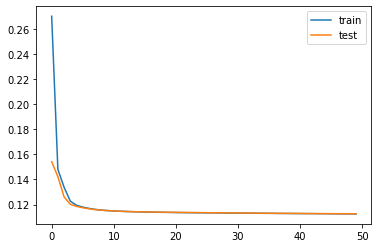

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Sample input using trained model
X_test_new=[[[0.22222222, 0.16666667, 0.69444444, 0.57575758, 0.82051282,
        0.375     , 0.625     , 0.2173913]]]
X_test_new=np.array(X_test_new)

In [ ]:
#Sample predicted output using trained model
yhat = model.predict(X_test_new)

In [ ]:
yhat

array([[0.19612592, 0.70366794, 0.5741198 , 0.82125765, 0.46403342,
        0.5494962 , 0.20420629, 0.20043562, 0.6532857 , 0.5980454 ,
        0.82979494, 0.4915997 , 0.29098654, 0.23725845, 0.20598409,
        0.6359131 , 0.49579397, 0.82952213, 0.5772105 , 0.28195953,
        0.23405647, 0.18648559, 0.6662495 , 0.643918  , 0.83299565,
        0.54330033, 0.23743252, 0.23440593]], dtype=float32)

In [ ]:
#Expected values for output
y_test[15]

array([0.11111111, 0.63888889, 0.52941176, 0.80952381, 0.52857143,
       0.08055556, 0.31914894, 0.11111111, 0.58333333, 0.53125   ,
       0.60465116, 0.56338028, 0.09722222, 0.375     , 0.        ,
       0.61111111, 0.475     , 0.7804878 , 0.69230769, 0.13333333,
       0.35416667, 0.        , 0.61111111, 0.62068966, 0.82051282,
       0.64383562, 0.06944444, 0.27659574])

In [ ]:
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
https://colab.research.google.com/drive/1yRX_EESFKTvRBocvxBrIW00EL-YJKg6w?authuser=2#scrollTo=2A2FVcdWbNil
https://pbpython.com/categorical-encoding.html